PyTorch DCGAN tutorial: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

Implements the DC-GAN paper

Generating 202599 images
Starting Epoch: 1


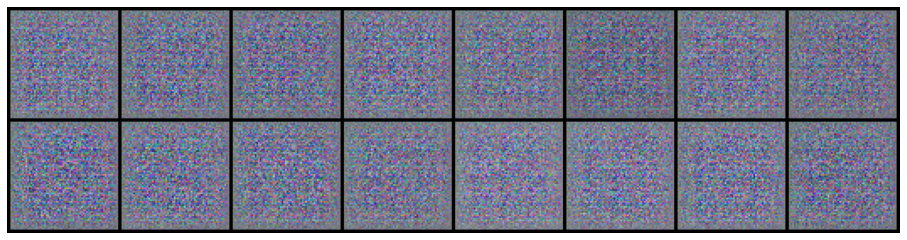

Epoch: [1/500], Batch Num: [0/792]
Discriminator Loss: 1.3870, Generator Loss: 0.6929
D(x): 0.4996, D(G(z)): 0.4999


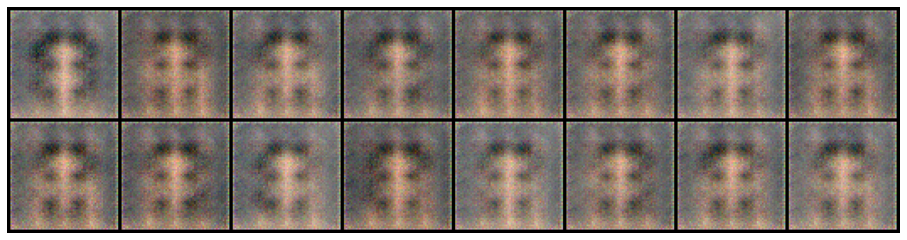

Epoch: [1/500], Batch Num: [100/792]
Discriminator Loss: 0.7538, Generator Loss: 0.8799
D(x): 0.8736, D(G(z)): 0.4460


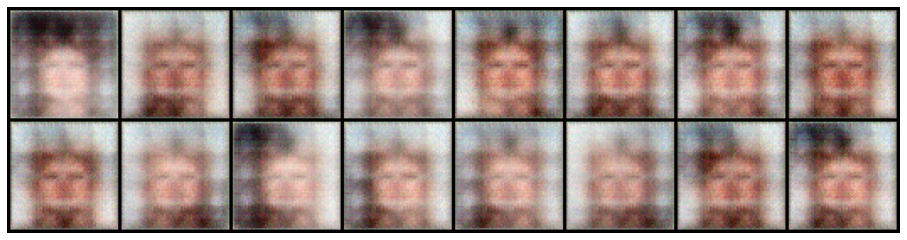

Epoch: [1/500], Batch Num: [200/792]
Discriminator Loss: 1.1517, Generator Loss: 0.5982
D(x): 0.7876, D(G(z)): 0.5889


In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.utils import data

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time 

from IPython.display import HTML


# Datasets
from data_loader.celeb_a_faces import CelebAFacesDataLoader
# Models
from models.gan import DCDiscriminatorNet, DCGeneratorNet
# Metrics
from utils.logger import Logger

def noise(batch_sz, dim):
  return torch.randn(batch_sz, dim, 1, 1)

# Main training function
def train(config, data_set):
  # setup seeds
  torch.manual_seed(config["seed"])
  torch.cuda.manual_seed(config["seed"])
  np.random.seed(config["seed"])
  torch.cuda.empty_cache()
    
  # setup device
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
  # setup dataloader
  train_data_set = data_set()
  train_data = data.DataLoader(train_data_set, batch_size=config["batch_sz"],\
                                num_workers=config["num_workers"], shuffle=True)
  num_batches = len(train_data)
  
  # setup models
  discriminator = DCDiscriminatorNet().to(device)
  generator = DCGeneratorNet(config["noise_dim"]).to(device)
    
  # setup optimizer
  d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5,0.999))
  g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5,0.999))
  # setup loss
  loss_fn = nn.BCELoss()
  #loss_fn = nn.BCEWithLogitsLoss()

  # setup tensorboard writer & checkpoint dir 
  uniq_name = f"{train_data_set.name}_VGAN_{config.get('exp_name', '')}"
  logger = Logger(uniq_name)
    
  i = 0
  # Load a saved checkpoint
  if config.get("resume_ckpoint") is not None:
    if os.path.isfile(config["resume_ckpoint"]):
      print(f"Loading checkpoint: {config['resume_ckpoint']}")
      ckpoint = torch.load(config["resume_ckpoint"])
      discriminator.load_state_dict(ckpoint["discriminator_state"])
      generator.load_state_dict(ckpoint["generator_state"])
      d_optimizer.load_state_dict(ckpoint["d_optimizer_state"])
      g_optimizer.load_state_dict(ckpoint["g_optimizer_state"])
      i = ckpoint["epoch"]
      print(f"Saved epoch: {i}, loss: {ckpoint['epoch_loss']}, time: {ckpoint['epoch_time']}")
    else:
      raise FileNotFoundError("Unable to load saved checkpoint!, Quitting")
  
  test_noise = noise(16, config["noise_dim"]).to(device)
  
  # Start the epochs. 
  while i < config["epochs"]:
    i += 1
    epoch_loss = 0
    epoch_time = 0
    # Prepare for training
    discriminator.train()
    generator.train()
        
    print(f"Starting Epoch: {i}")
    for b_i, (real_imgs, _) in enumerate(train_data):
      start_ts = time.time()
      real_imgs = real_imgs.to(device)
      batch_sz = real_imgs.shape[0]
      ## 1. Train the discriminator
      d_optimizer.zero_grad()
      
      # Train on real data
      pred_real = discriminator(real_imgs).view(-1)
      real_tgt = torch.ones(batch_sz, ).to(device)
      error_real = loss_fn(pred_real, real_tgt)
      error_real.backward()

      # Train on fake data
      # Generate some fake data using the generator.
      # Detach it here so that gradients are not computed for the 
      # generator when training the discriminator
      noise_vec = noise(batch_sz, config["noise_dim"]).to(device)
      fake_imgs = generator(noise_vec).detach()
      pred_fake = discriminator(fake_imgs).view(-1)
      fake_tgt = torch.zeros(batch_sz, ).to(device)
      error_fake = loss_fn(pred_fake, fake_tgt)
      error_fake.backward()
      #print(f"pred_fake {pred_fake}")
      # Update weights
      d_optimizer.step()
      
      ## 2. Train the generator
      g_optimizer.zero_grad()
      # Generate some fake data using the generator.
      noise_vec = noise(batch_sz, config["noise_dim"]).to(device)
      fake_imgs = generator(noise_vec)
      pred = discriminator(fake_imgs).view(-1)
      # compute loss wrt to 1s since we want the discriminator 
      # to be fooled to consider these as real
      real_tgt = torch.ones(batch_sz, ).to(device)
      error = loss_fn(pred, real_tgt) 
      error.backward()
      #print(f"disc: error_real {error_real} ... error_fake {error_fake}  ge error {error}")      
      # Update weights
      g_optimizer.step()

      ## Display Progress every few batches
      if (b_i) % 100 == 0: 
        test_imgs = generator(test_noise).cpu().data
        logger.log_images(test_imgs, i, b_i, num_batches)
        d_error=error_real+error_fake
        g_error=error
        logger.log_gan_error(d_error, g_error, i, b_i, num_batches)
        logger.display_gan_status(d_error, g_error, pred_real, pred_fake, i, config["epochs"], b_i, num_batches)
        
# Setup        
config = {"exp_name": "dcgan_1", "noise_dim": 100, "batch_sz": 256, "epochs": 500,\
          "seed": 1337, "num_workers": 1, "save_ckpoint": True} #"resume_ckpoint": "checkpoints/fcn32s_3.pkl", }

train(config, CelebAFacesDataLoader)
      
                                 